In [1]:
!pip install pyspark

import numpy as np 
import pandas as pd 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

from surprise import SVD
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.dump import dump
from surprise.dump import load

import seaborn as sns

sns.set(style="whitegrid")

from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType


from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql import SparkSession
from pyspark.sql import Row


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.4 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812364 sha256=9614f6f1b783622f2d841e97f756ba6b55b8e4a8929370003b5f293877fa8823
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


# Load Data

In [2]:
df=pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
print(df.shape)
df.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


# Basic Statistics

In [3]:
print("Data Info:")
print(df.info())

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None


**No null values**

**Plot the Distribution of ratings**

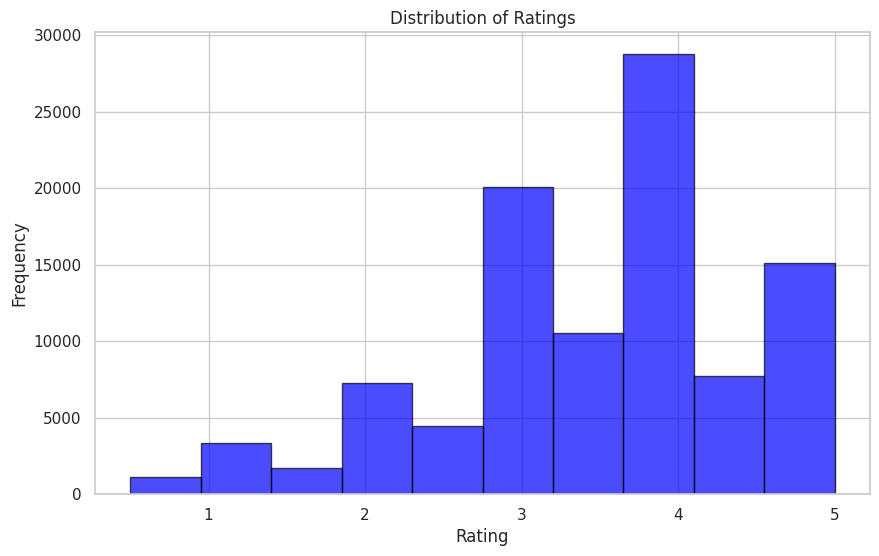

In [4]:
plt.figure(figsize=(10, 6))

# Create histogram
plt.hist(df['rating'].dropna(), bins=10, color='blue', edgecolor='black', alpha=0.7)

# Add titles and labels
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

**Plot Average rating per user**

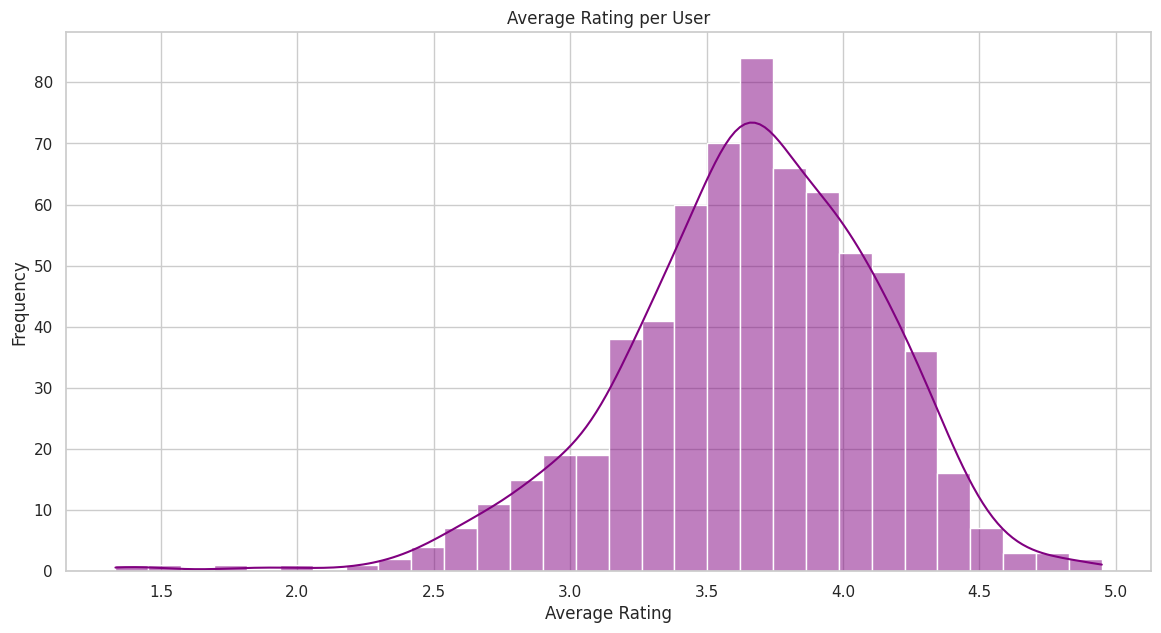

In [5]:
import warnings

# Average rating per user
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

plt.figure(figsize=(14, 7))
average_rating_per_user = df.groupby('userId')['rating'].mean().sort_values()
sns.histplot(average_rating_per_user, bins=30, kde=True, color='purple')
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()



# Build Interaction Matrix

In [6]:
movie_index_map = {movie: idx for idx, movie in enumerate(df['movieId'].unique())}
user_index_map = {user: idx for idx, user in enumerate(df['userId'].unique())}

row_indices = [user_index_map[user] for user in df['userId']]
col_indices = [movie_index_map[movie] for movie in df['movieId']]
interaction_values = df['rating']

interaction_matrix = csr_matrix((interaction_values, (row_indices, col_indices)),
                                 shape=(len(user_index_map), len(movie_index_map)))

print(interaction_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100004 stored elements and shape (671, 9066)>
  Coords	Values
  (0, 0)	2.5
  (0, 1)	3.0
  (0, 2)	3.0
  (0, 3)	2.0
  (0, 4)	4.0
  (0, 5)	2.0
  (0, 6)	2.0
  (0, 7)	2.0
  (0, 8)	3.5
  (0, 9)	2.0
  (0, 10)	2.5
  (0, 11)	1.0
  (0, 12)	4.0
  (0, 13)	4.0
  (0, 14)	3.0
  (0, 15)	2.0
  (0, 16)	2.0
  (0, 17)	2.5
  (0, 18)	1.0
  (0, 19)	3.0
  (1, 20)	4.0
  (1, 21)	5.0
  (1, 22)	5.0
  (1, 23)	4.0
  (1, 24)	4.0
  :	:
  (670, 996)	3.0
  (670, 1007)	3.0
  (670, 1028)	4.0
  (670, 1032)	4.0
  (670, 1041)	2.0
  (670, 1126)	4.0
  (670, 1129)	4.0
  (670, 1225)	2.0
  (670, 1240)	2.0
  (670, 1260)	4.0
  (670, 1299)	3.5
  (670, 1308)	4.5
  (670, 1329)	4.0
  (670, 1331)	2.5
  (670, 2174)	4.0
  (670, 2252)	4.0
  (670, 2529)	2.5
  (670, 2930)	2.5
  (670, 2946)	3.5
  (670, 4197)	4.0
  (670, 4480)	4.0
  (670, 4771)	4.0
  (670, 4823)	4.0
  (670, 5577)	4.0
  (670, 7005)	2.5


# Train SVD Model

In [7]:
reader = Reader(rating_scale=(0, 5))  
data = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

model = SVD()

cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
model.fit(trainset)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8964  0.8929  0.8984  0.8950  0.9006  0.8966  0.0026  
MAE (testset)     0.6885  0.6869  0.6901  0.6912  0.6954  0.6904  0.0029  
Fit time          1.38    1.44    1.73    1.80    1.83    1.63    0.19    
Test time         0.19    0.20    0.24    0.23    0.23    0.22    0.02    


In [8]:

model_filename = 'trained_model.pkl'
dump(model_filename, algo=model)
print(f"Model saved to {model_filename}")

Model saved to trained_model.pkl


In [9]:
loaded_model = load(model_filename)[1]
print("Model loaded successfully")

Model loaded successfully


**Load Meta Data to get Movie titles**

Movie titles are indexed by tmdb indexes so the relevant index must be found from links table before querying meta data table for movie title

In [ ]:
meta_df=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')

In [11]:
links_df=pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')

**Print top 10 recommendations for given users**

In [12]:
def get_top_n_recommendations(model, user_id, num_items, n=10):
    recommendations = []
    for item_id in range(1, num_items + 1):  # Assuming items are numbered from 1 to num_items
        prediction = model.predict(user_id, item_id)
        recommendations.append((item_id, prediction.est))
    
    # Sort recommendations by estimated rating
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    top_n_recommendations = recommendations[:n]
    return top_n_recommendations

user_id = 10
num_items = df['movieId'].nunique()  # Number of unique items in the dataset
top_recommendations = get_top_n_recommendations(model, user_id, num_items, n=10)
print("Top Recommendations for User", user_id)
for item_id, estimated_rating in top_recommendations:
    imdb_id = links_df[links_df['movieId'] == item_id]['tmdbId'].values[0]
    imdb_id= str(int(imdb_id))
   
    filtered_row = meta_df[meta_df['id'] == imdb_id]
   
    original_title = filtered_row['title'].values[0]
    print("Item:", original_title, "Estimated Rating:", estimated_rating)

Top Recommendations for User 10
Item: Modern Times Estimated Rating: 4.727071266109252
Item: Cinema Paradiso Estimated Rating: 4.596554686798231
Item: Citizen Kane Estimated Rating: 4.555407423150701
Item: The Usual Suspects Estimated Rating: 4.531592028683292
Item: Annie Hall Estimated Rating: 4.528974111596647
Item: The Pianist Estimated Rating: 4.485312652693451
Item: The Lord of the Rings: The Two Towers Estimated Rating: 4.473402638628683
Item: Ran Estimated Rating: 4.468828180754552
Item: Tom Jones Estimated Rating: 4.458054441708104
Item: The Shawshank Redemption Estimated Rating: 4.45604890607244


# ALS Model

# Load Data

In [13]:
df=pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv')
print(df.shape)
df.head()

(100004, 4)


,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

df = spark.read.options(header=True).csv("/kaggle/input/the-movies-dataset/ratings_small.csv")

In [15]:
df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [16]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")


Number of rows: 100004
Number of columns: 4


In [17]:
unique_users = df.select('userId').distinct()
unique_movies = df.select('movieId').distinct()
print(f"Number of unique users: {unique_users.count()}")
print(f"Number of unique movies: {unique_movies.count()}")


Number of unique users: 671
Number of unique movies: 9066


In [18]:
#Enumerate userids to a unique integer value
user_id_mapping = []
for i, u in enumerate(unique_users.collect()):
    user_id_mapping.append(Row(u['userId'], i))
    
#do the same for movies
movie_id_mapping = []
for i, m in enumerate(unique_movies.collect()):
    movie_id_mapping.append(Row(m['movieId'], i))

In [19]:
user_map = spark.createDataFrame(user_id_mapping, ['userId', 'int_user_id'])

In [20]:
movie_map = spark.createDataFrame(movie_id_mapping, ['movieId', 'int_movie_id'])

In [21]:
map_df = df.join(user_map, 'userId').join(movie_map, on='movieId')

In [22]:
map_df.show()


+-------+------+------+----------+-----------+------------+
|movieId|userId|rating| timestamp|int_user_id|int_movie_id|
+-------+------+------+----------+-----------+------------+
|  79132|   296|   5.0|1298159100|          0|         926|
|  56152|   296|   5.0|1298158941|          0|        5934|
|   6539|   296|   4.5|1298166284|          0|        7012|
|   4973|   296|   3.5|1298159035|          0|        3508|
|   4306|   296|   5.0|1298166290|          0|        7647|
|   4247|   296|   0.5|1298158913|          0|        2342|
|   4214|   296|   3.0|1298158801|          0|        5466|
|   4018|   296|   4.0|1298158655|          0|        1864|
|   3565|   296|   4.0|1298158907|          0|        1508|
|   3552|   296|   0.5|1298158632|          0|        8788|
|   3396|   296|   3.5|1298158686|          0|        8402|
|   3210|   296|   4.5|1298158651|          0|           2|
|   2423|   296|   5.0|1298158715|          0|         683|
|   2109|   296|   3.5|1298158675|      

In [23]:
user_movie = map_df[['int_user_id','int_movie_id','rating']]

In [24]:
from pyspark.sql.functions import col

# Convert 'rating' column to double type
user_movie = user_movie.withColumn("rating", col("rating").cast("double"))

# Verify the schema to ensure the conversion
user_movie.printSchema()

root
 |-- int_user_id: long (nullable = true)
 |-- int_movie_id: long (nullable = true)
 |-- rating: double (nullable = true)



In [25]:
user_movie.show(10)

+-----------+------------+------+
|int_user_id|int_movie_id|rating|
+-----------+------------+------+
|          0|         926|   5.0|
|          0|        5934|   5.0|
|          0|        7012|   4.5|
|          0|        3508|   3.5|
|          0|        7647|   5.0|
|          0|        2342|   0.5|
|          0|        5466|   3.0|
|          0|        1864|   4.0|
|          0|        1508|   4.0|
|          0|        8788|   0.5|
+-----------+------------+------+
only showing top 10 rows



In [26]:
(training, test) = user_movie.randomSplit([0.8, 0.2])

In [ ]:
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, regParam=0.01, userCol="int_user_id", itemCol="int_movie_id", ratingCol="rating",
          coldStartStrategy="drop")
model = als.fit(training)

In [28]:
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 1.120836360478334


**Load Meta Data to get Movie titles**

Movie titles are indexed by tmdb indexes so the relevant index must be found from links table before querying meta data table for movie title

In [ ]:
meta_df=pd.read_csv('/kaggle/input/the-movies-dataset/movies_metadata.csv')

In [30]:
links_df=pd.read_csv('/kaggle/input/the-movies-dataset/links.csv')

**Print top 10 recommendations for given users**

In [34]:
def get_rcmnds(k=6):
    # Generate top k recommendations for a specified set of users
    users = user_movie.select(als.getUserCol()).distinct().limit(1)
    userSubsetRecs = model.recommendForUserSubset(users, k)
    
    # Extract the user ID and recommended items with ratings
    user_row = userSubsetRecs.collect()[0]
    cid = user_row[0]
    recommendations = user_row[1]  # This is a list of Row objects

    # Extract movie IDs and ratings from recommendations
    aids = [row['int_movie_id'] for row in recommendations]
    ratings = [row['rating'] for row in recommendations]

    # Map movie IDs to external IDs
    rcmnds_df = movie_map.filter(movie_map.int_movie_id.isin(aids)).toPandas()
    rcmnds_df['rating'] = pd.Series(ratings)
    rcmnds = rcmnds_df[['movieId', 'rating']].values  # Array of [movieId, rating]

    # Retrieve previously watched movies
    prev_movies_int = user_movie.filter(user_movie.int_user_id == cid).toPandas()['int_movie_id'].values.tolist()
    prev_items = movie_map.filter(movie_map.int_movie_id.isin(prev_movies_int)).toPandas()['movieId'].values
    
    return rcmnds, prev_items
rcmnds, prev_items = get_rcmnds()

In [32]:
k = len(rcmnds)
for item, i in zip(rcmnds, range(1, k+1)):
        
    (Id, estimated_rating)=item
    estimated_rating=estimated_rating/2
    imdb_id = links_df[links_df['movieId'] == int(Id)]['tmdbId'].values[0]
    imdb_id= str(int(imdb_id))
   
    filtered_row = meta_df[meta_df['id'] == imdb_id]
   
    original_title = filtered_row['title'].values[0]
    print("Item:", original_title, "Estimated Rating:", estimated_rating)

Item: Dead Man Estimated Rating: 6.229127883911133
Item: K-19: The Widowmaker Estimated Rating: 6.089459419250488
Item: The Texas Chainsaw Massacre 2 Estimated Rating: 5.663971900939941
Item: Bicentennial Man Estimated Rating: 5.463295936584473
Item: Transformers: Revenge of the Fallen Estimated Rating: 5.438427448272705
Item: Even Cowgirls Get the Blues Estimated Rating: 5.297935485839844
